In [ ]:
# Parameters
run = "02_3_valid"
base_folder = "artificial_humans"
target = "valid"
selection = {"rnn": "True"}
test = ''
order = ["True", "False"]
pairs = [["True", "False"]]


In [46]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

data_folder = os.path.join('../../data', base_folder, run)
plot_folder = f'plots/{base_folder}_{run}'

make_dir(plot_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    cm = cm.sort_index(ascending=False)
    sns.heatmap(cm)

def merge_data(data_folder, metric_name):
    folder = os.path.join(data_folder, metric_name)
    dfs = [pd.read_parquet(os.path.join(folder, file)) for file in os.listdir(folder)]
    df = pd.concat(dfs).reset_index(drop=True)
    return df


In [48]:
metrics_df = merge_data(data_folder, 'metrics')
print(metrics_df['cv_split'].unique())
confusion_matrix_df = merge_data(data_folder, 'confusion_matrix')
metrics_df['shuffle_feature'] = metrics_df['shuffle_feature'].fillna('none')
labels = list(set(metrics_df.columns) - set(['job_id', 'name', 'value', 'cv_split', 'epoch', 'set', 'strategy', 'shuffle_feature']))


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. nan]


/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


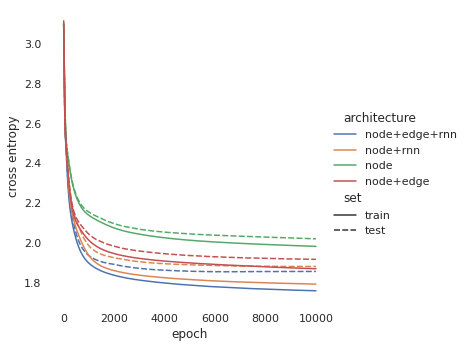

In [49]:
df = metrics_df.copy()


focus = [*labels, 'set']

sel = {
    'name': 'log_loss',
    'shuffle_feature': 'none',
}

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)

df = df[w]

fg = sns.relplot(
    data=df, 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

fg.set(ylabel='cross entropy')

fg.savefig(os.path.join(plot_folder, 'learning_curve_model.jpg'))

In [50]:
import statsmodels.formula.api as smf


df = metrics_df.copy()

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') &
    (df['shuffle_feature'] == 'none')
)
df = df[w].copy()
w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
df = df[w_max].copy()

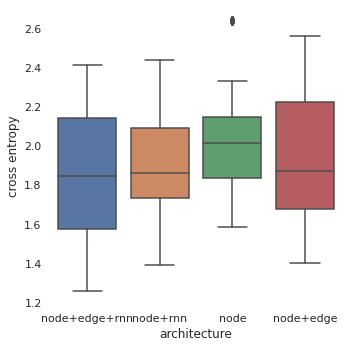

In [51]:
df = metrics_df.copy()

focus = labels

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') &
    (df['shuffle_feature'] == 'none')
)
df = df[w].copy()
w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
df = df[w_max].copy()


fg = sns.catplot(
    data=df, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box')

fg.set(ylabel='cross entropy')

fg.savefig(os.path.join(plot_folder, 'cross_entropy_box.jpg'))

node vs. node+edge: Mann-Whitney-Wilcoxon test two-sided, P_val:1.988e-01 U_stat=2.480e+02
node vs. node+rnn: Mann-Whitney-Wilcoxon test two-sided, P_val:1.017e-01 U_stat=2.610e+02
node vs. node+edge+rnn: Mann-Whitney-Wilcoxon test two-sided, P_val:1.264e-01 U_stat=2.570e+02


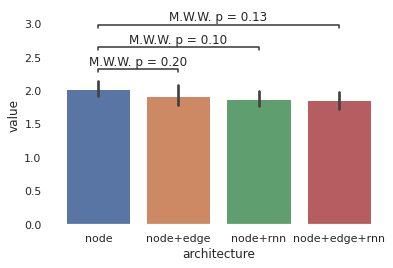

In [52]:
df = metrics_df.copy()

from statannotations.Annotator import Annotator

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') &
    (df['shuffle_feature'] == 'none')
)
df = df[w].copy()
w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
df = df[w_max].copy()

dfm = df.groupby([*labels, 'cv_split'])['value'].mean().reset_index()
dfm['mean_value'] = df.groupby(labels)['value'].transform('mean')

dfm[labels[0]] = dfm[labels[0]].astype(str)


ax = sns.barplot(
    data=dfm, 
    order=order,
    y='value',
    x=labels[0],
    errorbar=None
)
if pairs is not None:
    annotator = Annotator(ax, pairs, data=dfm, x=labels[0], y='value', order=order)
    annotator.configure(test=test, text_format='simple', loc='inside')
    annotator.apply_and_annotate()

plt.savefig(os.path.join(plot_folder, 'model_comparision.jpg'))

In [53]:
df = metrics_df.copy()

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') 
)
df = df[w].copy()

df_p = df.pivot(index=[*labels, 'name', 'cv_split', 'set', 'epoch'], columns='shuffle_feature', values='value')
df_p = df_p.sub(df_p['none'], axis=0)
df_p = df_p.stack()
df_p.name = 'value'
df_p = df_p.reset_index()
df_p = df_p[df_p['shuffle_feature'].isin(['prev_contributions', 'prev_punishments', 'prev_valid'])]

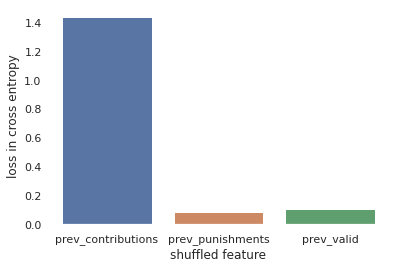

In [54]:
focus = ['shuffle_feature']

sel = {
    'name': 'log_loss',
    'set': 'test',
    **selection
}

w = pd.concat(
    (df_p[k].isin(v) if isinstance(v, list) else df_p[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)


dfs = df_p[w].copy()

ax = sns.barplot(
    data=df_p, 
    x='shuffle_feature', y='value',
    errorbar=None
)

ax.set(ylabel='loss in cross entropy', xlabel='shuffled feature')

plt.savefig(os.path.join(plot_folder, 'shuffle_feature_importance.jpg'))

/tmp/ipykernel_6771/2701744647.py:26: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([dfc, df]).reset_index()


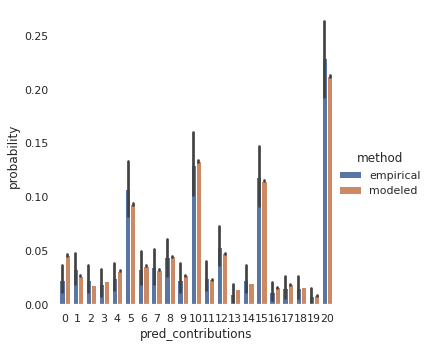

In [55]:
df = confusion_matrix_df.copy()

sel = {
    'round_number': 0,
    'valid': True,
    'set': 'test',
    **selection
}

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)


df = df[w]

dfc = df.copy()

dfc['probability'] = df[f'pred_{target}'] == df[f'true_{target}']
dfc['method'] = 'empirical'
df['probability'] = df['proba']
df['method'] = 'modeled'

df = pd.concat([dfc, df]).reset_index()

fg = sns.catplot(
    data=df, 
    x=f'pred_{target}', 
    y='probability',
    hue='method',
    height=5, kind='bar')

fg.savefig(os.path.join(plot_folder, 'action_histogram.jpg'))

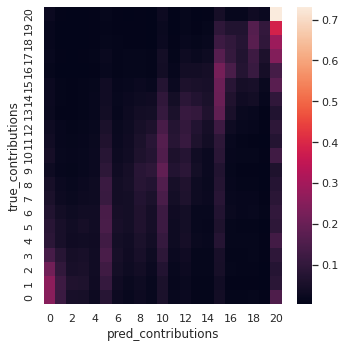

In [56]:
df = confusion_matrix_df.copy()

sel = {
    'valid': True,
    'set': 'test',
    **selection
}

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)

df = df[w]

dfc = df.copy()


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x=f'true_{target}',y=f'pred_{target}', values='proba')

fg = sns.FacetGrid(
    dfc, height=5)
fg.map_dataframe(plot_heatmap)


fg.savefig(os.path.join(plot_folder, 'confusion_matrix.jpg'))